Figure saved as Fig5.png

Node and Final Correlation Statistics
Station              N_Nodes    Max_Node_Corr      Final_Corr        
--------------------------------------------------------------------------------
changjiangtun        4          0.4965             0.7232             0.2267            
dalai                3          0.3500             0.5714             0.2214            
fuyu                 4          0.2416             0.7538             0.5123            
heishiguan           3          0.4056             0.4059             0.0003            
huaibin              6          0.4500             0.2381             -0.2119           
humaqiao             5          0.0818             0.6971             0.6152            
lianhua              4          0.4545             0.6284             0.1739            
liujiatun            5          1.0000             0.6574             -0.3426           
luanxian             3          -0.4544            0.7091             1.1

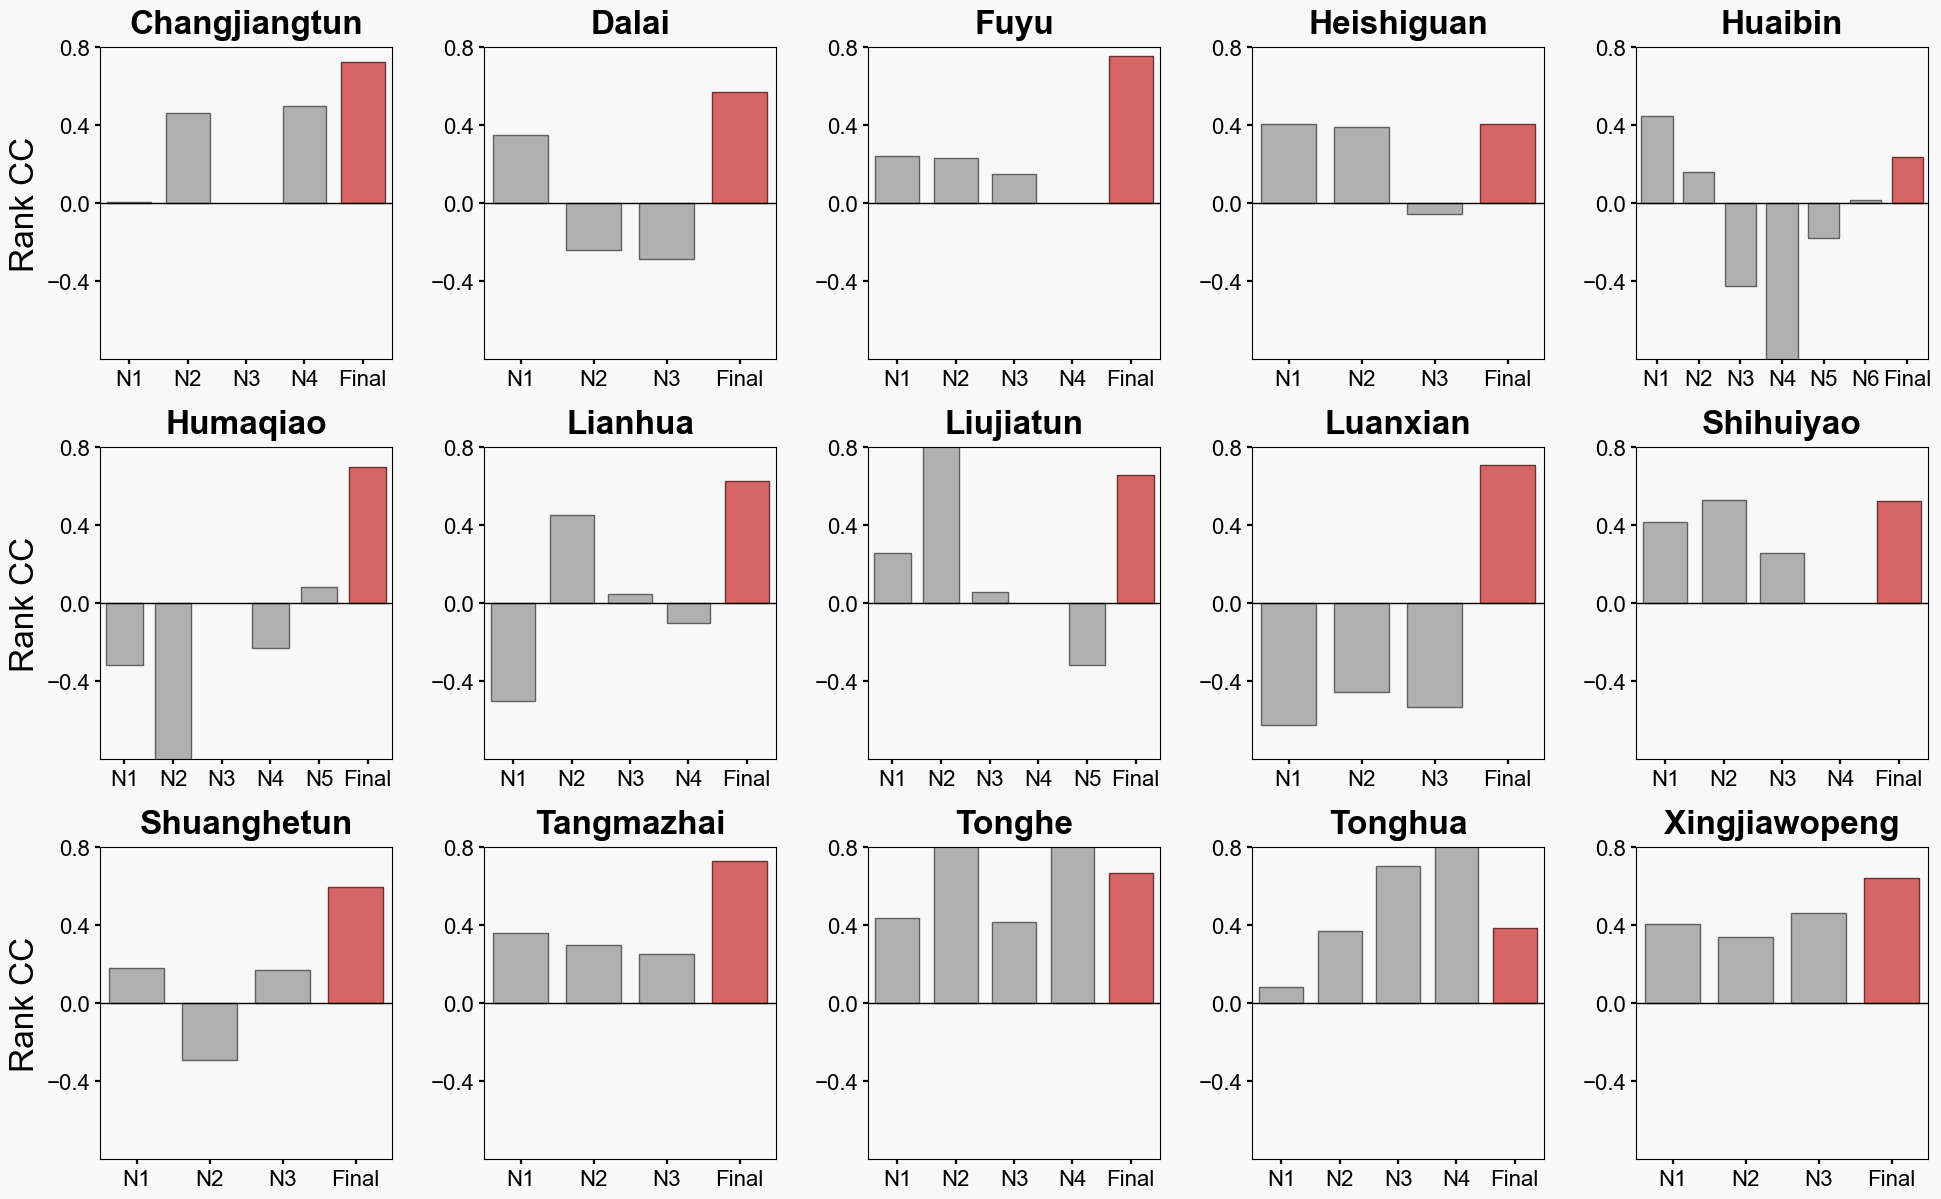

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Plot settings
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 16,
    'axes.titlesize': 24,
    'axes.labelsize': 24,
    'axes.titlepad': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'xtick.major.width': 1.6,
    'ytick.major.width': 1.6,
    'axes.facecolor': '#F8F8F8',
    'figure.facecolor': '#F8F8F8'
})

# Layout parameters
N_ROWS, N_COLS = 3, 5
BOUNDS = [0.12, 0.08, 0.76, 0.78]
MARGIN_LEFT, MARGIN_RIGHT, MARGIN_BOT, MARGIN_TOP = 0.04, 0, 0, 0

subplot_width = (1 - MARGIN_LEFT - MARGIN_RIGHT) / N_COLS
subplot_height = (1 - MARGIN_TOP - MARGIN_BOT) / N_ROWS
AXES_LEFT = MARGIN_LEFT + (np.arange(N_COLS) + BOUNDS[0]) * subplot_width
AXES_BOT = MARGIN_BOT + (np.arange(N_ROWS) + BOUNDS[1]) * subplot_height
AXES_WIDTH = subplot_width * BOUNDS[2]
AXES_HEIGHT = subplot_height * BOUNDS[3]

# Load and preprocess data
df = (pd.read_csv('./3-process/1.all_matched_points_VersionD.csv')
          .drop_duplicates(subset=['stationid', 'lat', 'lon'])
          .replace(-999999999999, np.nan)
          .dropna()
          .rename(columns={'STCD': 'siteid'}))

df['date'] = pd.to_datetime('2000-01-01') + pd.to_timedelta(df['time'], unit='s')
df['date'] = df['date'].dt.date

# 将date转换为datetime格式以便日期比较
df['date_dt'] = pd.to_datetime(df['date'])

# 筛选2025年4月及以前的数据
cutoff_date = pd.Timestamp('2025-04-30')
df_filtered = df[df['date_dt'] <= cutoff_date]

# 删除辅助列
df_all = df_filtered.drop(columns=['date_dt'])

df_comid = (pd.read_csv('./swot_w_h_north_china.csv')
            .rename(columns={'station': 'stationid'})[['siteid', 'stationid', 'COMID']]
            .drop_duplicates(subset='siteid'))

df_final_all = (pd.read_csv('./3-process/2.swot-points-selection_iqr_node_1.5_noqa_VersionD.csv')
                .rename(columns={'stationid': 'station'}))

station_final = (pd.read_csv('./3-process/5.q_kge_med_modified_q50_iqr_node_1.5_noqa_VersionD.csv')
                 .query("stationid != 'longmenzhen'"))

df_all = df_all.merge(df_comid, on='stationid', how='left')

# Sort nodes by ascending longitude
df_all['lon_mean'] = df_all.groupby('node_id')['lon'].transform('mean')
df_all = df_all.sort_values(['stationid', 'lon_mean'])

# Filter by uncertainty
df_all['width_u_r'] = df_all['width_u'] / df_all['width']
df_all = df_all[(df_all['wse_u'] <= 0.4) & (df_all['width_u_r'] <= 0.1)]

# Calculate rank correlation for each node
df_node_all = df_all[['node_id', 'stationid', 'lon_mean']].drop_duplicates(subset='node_id').copy()
df_node_all['rank_corr'] = df_node_all['node_id'].apply(
    lambda node: spearmanr(
        df_all.loc[df_all['node_id'] == node, 'width'],
        df_all.loc[df_all['node_id'] == node, 'wse']
    )[0]
)

stations = sorted(station_final['stationid'].unique())

# Create statistics dataframe
stats_list = []

# Create figure
fig = plt.figure(figsize=(20, 12))
axes = [[plt.axes([AXES_LEFT[j], AXES_BOT[i], AXES_WIDTH, AXES_HEIGHT])
         for j in range(min(N_COLS, len(stations) - (N_ROWS - 1 - i) * N_COLS))]
        for i in range(N_ROWS - 1, -1, -1)]

# Main plotting loop
for panel, station in enumerate(stations):
    row, col = panel // N_COLS, panel % N_COLS
    ax = axes[row][col]
    
    # Get data for this station
    df_node = df_node_all[df_node_all['stationid'] == station]
    df_final = df_final_all[df_final_all['station'] == station]
    
    corr_node = df_node['rank_corr'].values
    n_nodes = len(corr_node)
    
    # Calculate max node correlation (ignoring NaN values)
    max_node_corr = np.nanmax(corr_node) if len(corr_node) > 0 and not np.all(np.isnan(corr_node)) else np.nan
    
    # Calculate final correlation if data exists
    has_final = len(df_final) > 1
    corr_final = spearmanr(df_final['width'], df_final['wse'])[0] if has_final else np.nan
    
    # Store statistics
    stats_list.append({
        'stationid': station,
        'n_nodes': n_nodes,
        'max_node_corr': max_node_corr,
        'final_corr': corr_final
    })
    
    # Plot node bars
    x_nodes = np.arange(n_nodes)
    ax.bar(x_nodes, corr_node, width=0.75, fc='#B0B0B0', ec='#606060', lw=1, zorder=0)
    
    # Plot final bar (positioned after the last node)
    x_final = n_nodes
    if has_final and not np.isnan(corr_final):
        ax.bar(x_final, corr_final, width=0.75, fc='#D56565', ec='#703030', lw=1, zorder=0)
    
    # Zero line
    total_bars = n_nodes + (1 if has_final else 0)
    ax.axhline(0, color='black', lw=1, zorder=1)
    
    # Dynamic x-axis settings
    ax.set_xlim(-0.5, total_bars - 0.5)
    ax.set_ylim(-0.8, 0.8)
    
    # Create labels: N1, N2, ..., Nn, Final
    labels = [f'N{i+1}' for i in range(n_nodes)]
    if has_final:
        labels.append('Final')
    
    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticks(np.arange(-0.4, 1, 0.4))
    ax.set_title(station.capitalize(), fontweight='bold')
    
    if col == 0:
        ax.set_ylabel('Rank CC')

plt.savefig('Fig5.png', dpi=200)
print("Figure saved as Fig5.png")

# Create and save statistics dataframe
df_stats = pd.DataFrame(stats_list)
df_stats.to_csv('node_correlation_statistics.csv', index=False)

# Print statistics
print("\n" + "="*80)
print("Node and Final Correlation Statistics")
print("="*80)
print(f"{'Station':<20} {'N_Nodes':<10} {'Max_Node_Corr':<18} {'Final_Corr':<18}")
print("-"*80)

for _, row in df_stats.iterrows():
    station = row['stationid']
    n_nodes = int(row['n_nodes'])
    max_node = row['max_node_corr']
    final = row['final_corr']
    dif = row['final_corr']-row['max_node_corr']
    
    max_node_str = f"{max_node:.4f}" if not np.isnan(max_node) else "N/A"
    final_str = f"{final:.4f}" if not np.isnan(final) else "N/A"
    dif_str = f"{dif:.4f}" if not np.isnan(dif) else "N/A"
    
    print(f"{station:<20} {n_nodes:<10} {max_node_str:<18} {final_str:<18} {dif_str:<18}")

print("-"*80)
print(f"\nSummary statistics:")
print(f"  Average max node correlation: {df_stats['max_node_corr'].mean():.4f}")
print(f"  Average final correlation: {df_stats['final_corr'].mean():.4f}")
print(f"  Stations where final > max node: {(df_stats['final_corr'] > df_stats['max_node_corr']).sum()}")
print(f"  Stations where final < max node: {(df_stats['final_corr'] < df_stats['max_node_corr']).sum()}")
print("\nStatistics saved to: node_correlation_statistics.csv")
print("="*80)